In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/resnet/best_model.ckpt
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/ch

In [2]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from pytorch_lightning import LightningModule, Trainer
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.transforms.functional import InterpolationMode
from torch.nn import Linear
from pytorch_lightning.callbacks import ModelCheckpoint  # Import ModelCheckpoint

# Constants
BATCHSIZE = 64
CLASSES = 2  # Update with the number of classes in your dataset
EPOCHS = 30
DIR = os.getcwd()
SEED = 42

# Set random seed for reproducibility
torch.manual_seed(SEED)

# Define transformations
transform_train = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Define the path to your dataset
kaggle_data_path = "/kaggle/input/chest-xray-pneumonia/chest_xray"

# Data loading using ImageFolder
train_dataset = ImageFolder(root=os.path.join(kaggle_data_path, 'train'), transform=transform_train)
val_dataset = ImageFolder(root=os.path.join(kaggle_data_path, 'val'), transform=transform_test)
test_dataset = ImageFolder(root=os.path.join(kaggle_data_path, 'test'), transform=transform_test)

# Split train dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCHSIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCHSIZE)

class Net(nn.Module):   
    def __init__(self, num_classes):
        super(Net, self).__init__()
        
        # Load pre-trained ResNet50 from SwAV
        swav = torch.hub.load('facebookresearch/swav:main', 'resnet50')  
        self.backbone1 = nn.Sequential(*(list(swav.children())[:-1]))  # Adjust to remove last layer (adaptive pooling)

        # Replace the final layer with a linear layer
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        # Forward pass through the SwAV backbone
        features = self.backbone1(x)
        
        # Flatten the output
        features = features.view(x.size(0), -1)
        
        # Fully connected layer
        output = self.fc(features)
        
        return output

# LightningModule definition
class LightningNetTeacher(LightningModule):
    def __init__(self):
        super(LightningNetTeacher, self).__init__()
        self.teacher_model = Net(CLASSES)  # Pass the number of classes

    def forward(self, x):
        return self.teacher_model(x)

    def training_step(self, batch, batch_idx):
        data, target = batch
        output = self.teacher_model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        data, target = batch
        output = self.teacher_model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        pred = output.argmax(dim=1, keepdim=True)
        accuracy = pred.eq(target.view_as(pred)).float().mean()
        self.log('val_loss', loss)
        self.log('val_acc', accuracy)
        return accuracy

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.05, weight_decay=1e-4, momentum=0.9, nesterov=True)
        scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

# Initialize model
model = LightningNetTeacher()

# Define checkpoint callback to save the best model
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',
    dirpath=DIR,
    filename='best_model',
    mode='max'
)

# Initialize trainer
trainer = Trainer(
    max_epochs=EPOCHS,
    accelerator='gpu' if torch.cuda.is_available() else None,
    callbacks=[checkpoint_callback]
)

# Train the model
trainer.fit(model, train_loader, val_loader)

Downloading: "https://github.com/facebookresearch/swav/zipball/main" to /root/.cache/torch/hub/main.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://dl.fbaipublicfiles.com/deepcluster/swav_800ep_pretrain.pth.tar" to /root/.cache/torch/hub/checkpoints/swav_800ep_pretrain.pth.tar
100%|██████████| 108M/108M [00:00<00:00, 253MB/s]  
2024-04-11 10:41:07.474548: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [3]:
import torch
from torchvision.models import resnet18

# Load the saved state dictionary
checkpoint = torch.load('/kaggle/working/best_model.ckpt')
model_state_dict = checkpoint.get('state_dict', checkpoint)

# Create a new instance of ResNet18 model
student_model = resnet18(pretrained=False)

# Check the architecture of the student model
print(student_model)  # Check if this is indeed ResNet18

# Load the state dictionary into the model
try:
    # Verify model parameters before loading state dictionary
    print("Keys in model's state_dict before loading:", student_model.state_dict().keys())

    student_model.load_state_dict(model_state_dict)

    # Verify model parameters after loading state dictionary
    print("Keys in model's state_dict after loading:", student_model.state_dict().keys())
except RuntimeError as e:
    print(f"Error loading state dictionary: {e}")
    print("The saved state dictionary might not be compatible with the ResNet18 architecture.")
else:
    # Modify the final fully connected layer
    # Note: You might need to define 'train_dataset' before using it here
    student_model.fc = torch.nn.Linear(student_model.fc.in_features, len(train_dataset.classes))
    print("Pre-trained ResNet18 model weights loaded successfully.")


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
pip install optuna-integration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 946.8 kB/s eta 0:00:000:00:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
from optuna.integration.pytorch_lightning import PyTorchLightningPruningCallback

In [8]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import InterpolationMode
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchmetrics import Accuracy
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from optuna.samplers import TPESampler, RandomSampler
from optuna.visualization import (
    plot_contour, plot_edf, plot_intermediate_values, plot_optimization_history,
    plot_parallel_coordinate, plot_param_importances, plot_slice
)
from optuna.trial import TrialState
from optuna.integration import PyTorchLightningPruningCallback
import optuna
from packaging import version

# Set device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.cuda.empty_cache()

# Constants
BATCHSIZE = 64
CLASSES = 2  # Update with the number of classes in your dataset
EPOCHS = 30
DIR = os.getcwd()
SEED = 42

# Set random seed for reproducibility
torch.manual_seed(SEED)

# Define transformations
transform_train = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Define the path to your dataset
kaggle_data_path = "/kaggle/input/chest-xray-pneumonia/chest_xray"

# Data loading using ImageFolder
train_dataset = ImageFolder(root=os.path.join(kaggle_data_path, 'train'), transform=transform_train)
val_dataset = ImageFolder(root=os.path.join(kaggle_data_path, 'val'), transform=transform_test)
test_dataset = ImageFolder(root=os.path.join(kaggle_data_path, 'test'), transform=transform_test)

# Split train dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCHSIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCHSIZE)


# Teacher model definition
class Net_teacher(nn.Module):
    def __init__(self):
        super(Net_teacher, self).__init__()
        resnet50 = models.resnet50(pretrained=False)
        self.backbone = nn.Sequential(*(list(resnet50.children())))
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear_layers = nn.Linear(2048, CLASSES)

    def forward(self, x):
        x = self.backbone(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

# Student model definition
class Net_student(nn.Module):
    def __init__(self, output_dim_fc1, output_dim_fc2, dropout_rate):
        super(Net_student, self).__init__()
        self.backbone_student = models.resnet18(pretrained=False)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Sequential(
            nn.Linear(512, output_dim_fc1),
            nn.BatchNorm1d(output_dim_fc1),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(output_dim_fc1, output_dim_fc2),
            nn.BatchNorm1d(output_dim_fc2),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        self.linear_layers = nn.Linear(output_dim_fc2, CLASSES)

    def forward(self, x):
        x = self.backbone_student(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.linear_layers(x)
        return x

# LightningModule for teacher model
class LightningNet_teacher(pl.LightningModule):
    def __init__(self):
        super(LightningNet_teacher, self).__init__()
        self.teacher_model = Net_teacher()

    def forward(self, data):
        return self.teacher_model(data)

# LightningModule for student model
class LightningNet_student(pl.LightningModule):
    def __init__(self, output_dim_fc1, output_dim_fc2, dropout_rate, alpha, beta, temperature, learning_rate):
        super(LightningNet_student, self).__init__()
        self.student_model = Net_student(output_dim_fc1, output_dim_fc2, dropout_rate)
        self.alpha = alpha
        self.beta = beta
        self.temperature = temperature
        self.learning_rate = learning_rate

    def forward(self, data):
        return self.student_model(data)

    def training_step(self, batch, batch_idx):
        data, target = batch
        student_output = self.student_model(data)
        with torch.no_grad():
            teacher_output = model_teacher(data)
        
        kl_loss = nn.KLDivLoss(reduction="batchmean")(
            nn.LogSoftmax(dim=1)(student_output / self.temperature),
            nn.Softmax(dim=1)(teacher_output / self.temperature)
        ) * self.temperature * self.temperature
        ce_loss = nn.CrossEntropyLoss()(student_output, target)
        loss = self.alpha * kl_loss + (1 - self.alpha) * ce_loss + self.beta * c_barlo
        return loss

    def validation_step(self, batch, batch_idx):
        data, target = batch
        output = self.student_model(data)
        loss = F.cross_entropy(output, target)
        pred = output.argmax(dim=1, keepdim=True)
        accuracy = pred.eq(target.view_as(pred)).float().mean()
        self.log("val_acc", accuracy)
        return {'val_loss': loss}

    def test_step(self, batch, batch_idx):
        data, target = batch
        output = self.student_model(data)
        loss = F.cross_entropy(output, target)
        pred = output.argmax(dim=1, keepdim=True)
        accuracy = pred.eq(target.view_as(pred)).float().mean()
        self.log("test_loss", loss)
        self.log("test_acc", accuracy)
        return {'test_loss': loss}

# Load the checkpoint
chk_path = '/kaggle/input/resnet/best_model.ckpt'
checkpoint = torch.load(chk_path, map_location=torch.device('cpu'))

# Checkpoint keys inspection
print(checkpoint.keys())

# Instantiate your model
model = Net_teacher()

# Load state_dict from the checkpoint
state_dict = checkpoint['state_dict']

# Filter out unexpected keys
unexpected_keys = [k for k in state_dict.keys() if k not in model.state_dict()]
for k in unexpected_keys:
    del state_dict[k]

# Load filtered state_dict into your model
model.load_state_dict(state_dict, strict=False)

# Move the model to the appropriate device if using GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers'])


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Net_teacher(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [9]:
!pip install --upgrade pytorch-lightning

In [10]:
class LightningNet_student(pl.LightningModule):
    def __init__(self, output_dim_fc1, output_dim_fc2, dropout_rate, alpha, beta, temperature, learning_rate):
        super(LightningNet_student, self).__init__()
        self.student_model = Net_student(output_dim_fc1, output_dim_fc2, dropout_rate)
        self.alpha = alpha
        self.beta = beta
        self.temperature = temperature
        self.learning_rate = learning_rate

    def forward(self, data):
        return self.student_model(data)

    def training_step(self, batch, batch_idx):
        data, target = batch
        student_output = self.student_model(data)
        with torch.no_grad():
            teacher_output = model_teacher(data)
        
        kl_loss = nn.KLDivLoss(reduction="batchmean")(
            nn.LogSoftmax(dim=1)(student_output / self.temperature),
            nn.Softmax(dim=1)(teacher_output / self.temperature)
        ) * self.temperature * self.temperature
        ce_loss = nn.CrossEntropyLoss()(student_output, target)
        loss = self.alpha * kl_loss + (1 - self.alpha) * ce_loss + self.beta * c_barlo
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        data, target = batch
        output = self.student_model(data)
        loss = F.cross_entropy(output, target)
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        return {'val_loss': loss}

    def test_step(self, batch, batch_idx):
        data, target = batch
        output = self.student_model(data)
        loss = F.cross_entropy(output, target)
        self.log("test_loss", loss)
        return {'test_loss': loss}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.student_model.parameters(), lr=self.learning_rate)
        return optimizer

In [11]:
class Net_student(nn.Module):
    def __init__(self, output_dim_fc1, output_dim_fc2, dropout_rate):
        super(Net_student, self).__init__()
        self.backbone_student = models.resnet18(pretrained=False)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Update the output size
        self.fc1 = nn.Linear(512, output_dim_fc1)
        self.fc2 = nn.Linear(output_dim_fc1, output_dim_fc2)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.backbone_student(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import pytorch_lightning as pl

class LightningNet_student(pl.LightningModule):
    def __init__(self, output_dim_fc1, output_dim_fc2, dropout_rate, alpha, beta, temperature, learning_rate):
        super(LightningNet_student, self).__init__()
        self.student_model = Net_student(output_dim_fc1, output_dim_fc2, dropout_rate)
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.student_model.backbone_student(x)  # Access backbone_student from student_model

    

    def training_step(self, batch, batch_idx):
        data, target = batch
        output = self(data)
        loss = F.cross_entropy(output, target)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        data, target = batch
        output = self(data)
        loss = F.cross_entropy(output, target)
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

class Net_student(nn.Module):
    def __init__(self, output_dim_fc1, output_dim_fc2, dropout_rate):
        super(Net_student, self).__init__()
        self.backbone_student = models.resnet18(pretrained=False)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, output_dim_fc1)
        self.fc2 = nn.Linear(output_dim_fc1, output_dim_fc2)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.backbone_student(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
train_loader = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCHSIZE)

# Define the parameters
output_dim_fc1 = 256
output_dim_fc2 = 128
dropout_rate = 0.5
alpha = 0.5
beta = 0.5
temperature = 0.5
learning_rate = 0.001

# Initialize LightningModule
student_model = LightningNet_student(output_dim_fc1, output_dim_fc2, dropout_rate, alpha, beta, temperature, learning_rate)

# Initialize PyTorch Lightning Trainer
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    accelerator="gpu" if torch.cuda.is_available() else "cpu"
)

# Train the model
trainer.fit(student_model, train_loader, val_loader)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [13]:
class Net_student(nn.Module):
    def __init__(self, output_dim_fc1, output_dim_fc2, dropout_rate):
        super(Net_student, self).__init__()
        self.backbone_student = models.resnet18(pretrained=False)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, output_dim_fc1)
        self.fc2 = nn.Linear(output_dim_fc1, output_dim_fc2)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.backbone_student(x)
        # Ensure the spatial dimensions are preserved
        x = self.avgpool(x) if x.dim() > 2 else x
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [16]:
import numpy as np

# Assuming you have 1000 training samples and 200 validation samples
num_train_samples = 5216
num_val_samples = 16
image_shape = (3,224,224)  # Example image shape (32x32 RGB image)

# Generate random training data
x_train = np.random.rand(num_train_samples, *image_shape)  # Random images
y_train = np.random.randint(0, 10, num_train_samples)       # Random labels (assuming 10 classes)

# Generate random validation data
x_val = np.random.rand(num_val_samples, *image_shape)      # Random images
y_val = np.random.randint(0, 10, num_val_samples)    

In [17]:
import numpy as np
import torch
from torch.utils.data import TensorDataset

# Define the number of validation samples, image shape, and number of classes
num_val_samples = 16
image_shape = (3, 224, 224)

# Generate random images and labels for the validation set
x_val = np.random.rand(num_val_samples, *image_shape)  # Random images
y_val = np.random.randint(0, 10, num_val_samples)  # Random labels

# Convert the numpy arrays to PyTorch tensors and create a dataset
x_val = torch.FloatTensor(x_val)
y_val = torch.LongTensor(y_val)
val_dataset = TensorDataset(x_val, y_val)

Epoch 1/20, Train Loss: 626.2564, Val Loss: 756.0190
Epoch 2/20, Train Loss: 512.6054, Val Loss: 571.4905
Epoch 3/20, Train Loss: 358.5213, Val Loss: 361.5712
Epoch 4/20, Train Loss: 273.8112, Val Loss: 503.2888
Epoch 5/20, Train Loss: 27.5712, Val Loss: 57.7423
Epoch 6/20, Train Loss: 0.7468, Val Loss: 40.8191
Epoch 7/20, Train Loss: 0.4853, Val Loss: 42.1073
Epoch 8/20, Train Loss: 0.5763, Val Loss: 52.9283
Epoch 9/20, Train Loss: 0.1902, Val Loss: 24.9661
Epoch 10/20, Train Loss: 0.3680, Val Loss: 52.8938
Epoch 11/20, Train Loss: 0.8405, Val Loss: 45.1640
Epoch 12/20, Train Loss: 0.0283, Val Loss: 21.7026
Epoch 13/20, Train Loss: 0.0053, Val Loss: 24.8859
Epoch 14/20, Train Loss: 0.0081, Val Loss: 18.4426
Epoch 15/20, Train Loss: 0.0000, Val Loss: 18.4417
Epoch 16/20, Train Loss: 0.0000, Val Loss: 18.4417
Epoch 17/20, Train Loss: 0.0000, Val Loss: 18.4417
Epoch 18/20, Train Loss: 0.0000, Val Loss: 18.4417
Epoch 19/20, Train Loss: 0.0000, Val Loss: 18.4417
Epoch 20/20, Train Loss: 0.

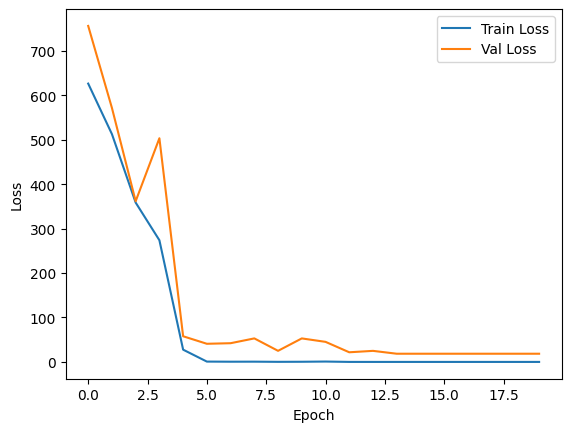

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# Define your model class
class student_model(nn.Module):
    def __init__(self):
        super(student_model, self).__init__()
        self.flatten = nn.Flatten()  # Flatten the input
        self.fc = nn.Linear(3 * 224 * 224, 10)  # Adjusted linear layer for 10 classes

    def forward(self, x):
        x = self.flatten(x)  # Flatten the input
        return self.fc(x)

# Instantiate your model
model = student_model()

# Check if the model has parameters
if list(model.parameters()):
    # Define your optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
else:
    print("The model has no parameters.")

# Assuming you have your training and validation data loaded into tensors x_train, y_train, x_val, y_val
# Here, y_train and y_val should contain integers representing class labels

# Assuming you have defined the number of epochs and batch size
num_epochs = 20
batch_size = 32

# Define your loss function
criterion = nn.CrossEntropyLoss()

# Create DataLoader objects for training and validation data
train_dataset = TensorDataset(torch.FloatTensor(x_train), torch.LongTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(x_val), torch.LongTensor(y_val))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Training loop
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    # Training
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize
        running_loss += loss.item() * inputs.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)  # Forward pass
            val_loss = criterion(outputs, labels)  # Compute the loss
            val_running_loss += val_loss.item() * inputs.size(0)
    val_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# After training, you can plot the loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


   

Epoch 1/20, Train Loss: 661.1408, Val Loss: 834.9887
Epoch 2/20, Train Loss: 556.0387, Val Loss: 842.7448
Epoch 3/20, Train Loss: 460.2791, Val Loss: 745.8500
Epoch 4/20, Train Loss: 225.0465, Val Loss: 184.1649
Epoch 5/20, Train Loss: 53.1348, Val Loss: 70.1905
Epoch 6/20, Train Loss: 0.2030, Val Loss: 32.6087
Epoch 7/20, Train Loss: 0.0390, Val Loss: 44.7627
Epoch 8/20, Train Loss: 0.0136, Val Loss: 24.1949
Epoch 9/20, Train Loss: 0.0021, Val Loss: 36.4881
Epoch 10/20, Train Loss: 0.0199, Val Loss: 38.5638
Epoch 11/20, Train Loss: 0.0000, Val Loss: 19.8123
Epoch 12/20, Train Loss: 0.0000, Val Loss: 19.8123
Epoch 13/20, Train Loss: 0.0000, Val Loss: 19.8123
Epoch 14/20, Train Loss: 0.0000, Val Loss: 19.8123
Epoch 15/20, Train Loss: 0.0000, Val Loss: 19.8123
Epoch 16/20, Train Loss: 0.0000, Val Loss: 19.8123
Epoch 17/20, Train Loss: 0.0000, Val Loss: 19.8123
Epoch 18/20, Train Loss: 0.0000, Val Loss: 19.8123
Epoch 19/20, Train Loss: 0.0000, Val Loss: 19.8123
Epoch 20/20, Train Loss: 0.

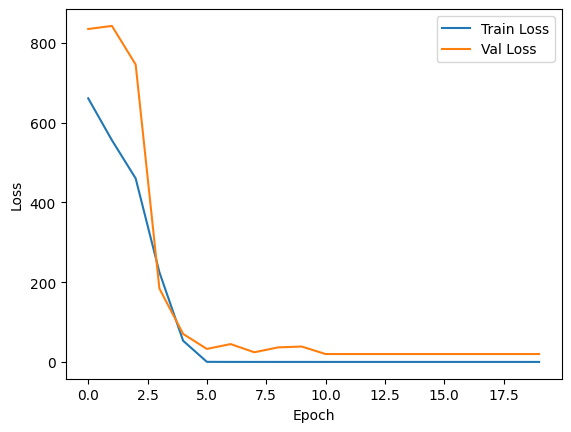

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# Define your model class
class teacher_model(nn.Module):
    def __init__(self):
        super(teacher_model, self).__init__()
        self.flatten = nn.Flatten()  # Flatten the input
        self.fc = nn.Linear(3 * 224 * 224, 10)  # Adjusted linear layer for 10 classes

    def forward(self, x):
        x = self.flatten(x)  # Flatten the input
        return self.fc(x)

# Instantiate your model
model = teacher_model()

# Check if the model has parameters
if list(model.parameters()):
    # Define your optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
else:
    print("The model has no parameters.")

# Assuming you have your training and validation data loaded into tensors x_train, y_train, x_val, y_val
# Here, y_train and y_val should contain integers representing class labels

# Assuming you have defined the number of epochs and batch size
num_epochs = 20
batch_size = 32

# Define your loss function
criterion = nn.CrossEntropyLoss()

# Create DataLoader objects for training and validation data
train_dataset = TensorDataset(torch.FloatTensor(x_train), torch.LongTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(x_val), torch.LongTensor(y_val))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Training loop
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    # Training
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize
        running_loss += loss.item() * inputs.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)  # Forward pass
            val_loss = criterion(outputs, labels)  # Compute the loss
            val_running_loss += val_loss.item() * inputs.size(0)
    val_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# After training, you can plot the loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/30, Train Loss: 634.6548, Val Loss: 474.0574, Train Acc: 0.1948, Val Acc: 0.0625
Epoch 2/30, Train Loss: 560.9608, Val Loss: 682.9521, Train Acc: 0.1060, Val Acc: 0.0625
Epoch 3/30, Train Loss: 459.1077, Val Loss: 514.5723, Train Acc: 0.1455, Val Acc: 0.0625
Epoch 4/30, Train Loss: 261.7405, Val Loss: 254.3341, Train Acc: 0.3035, Val Acc: 0.0625
Epoch 5/30, Train Loss: 113.7321, Val Loss: 140.8202, Train Acc: 0.7145, Val Acc: 0.0000
Epoch 6/30, Train Loss: 1.5014, Val Loss: 28.2361, Train Acc: 0.9996, Val Acc: 0.0625
Epoch 7/30, Train Loss: 0.2310, Val Loss: 50.9374, Train Acc: 0.9712, Val Acc: 0.0625
Epoch 8/30, Train Loss: 0.0715, Val Loss: 41.9804, Train Acc: 0.9994, Val Acc: 0.0000
Epoch 9/30, Train Loss: 0.0759, Val Loss: 72.7846, Train Acc: 0.9837, Val Acc: 0.0625
Epoch 10/30, Train Loss: 0.0618, Val Loss: 35.6985, Train Acc: 1.0000, Val Acc: 0.0000
Epoch 11/30, Train Loss: 0.0000, Val Loss: 35.1647, Train Acc: 1.0000, Val Acc: 0.0000
Epoch 12/30, Train Loss: 0.0000, Val 

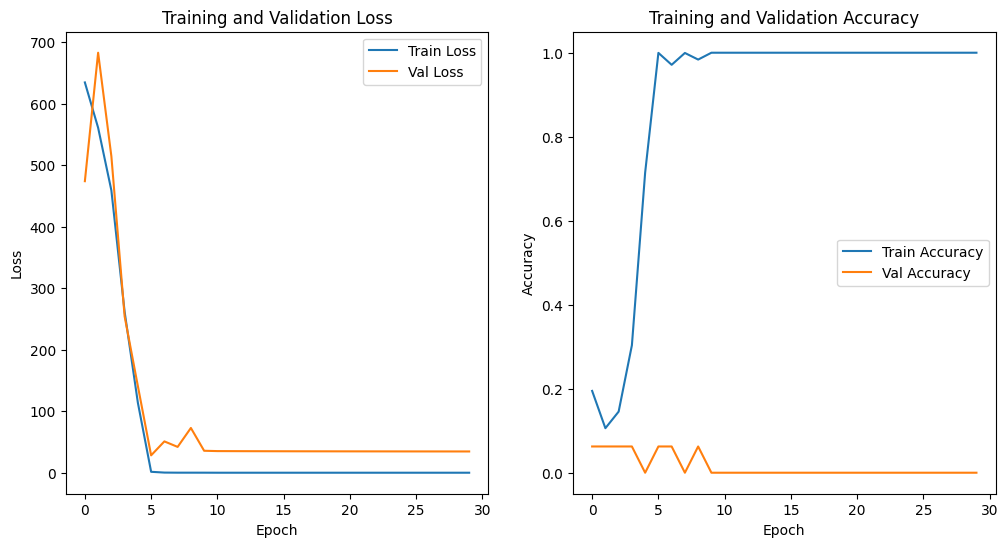

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# Define your model class
class student_model(nn.Module):
    def __init__(self):
        super(student_model, self).__init__()
        self.flatten = nn.Flatten()  # Flatten the input
        self.fc = nn.Linear(3 * 224 * 224, 10)  # Adjusted linear layer for 10 classes

    def forward(self, x):
        x = self.flatten(x)  # Flatten the input
        return self.fc(x)

# Function to calculate accuracy
def calculate_accuracy(model, data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Instantiate your model
model = student_model()

# Check if the model has parameters
if list(model.parameters()):
    # Define your optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
else:
    print("The model has no parameters.")

# Assuming you have your training and validation data loaded into tensors x_train, y_train, x_val, y_val
# Here, y_train and y_val should contain integers representing class labels

# Assuming you have defined the number of epochs and batch size
num_epochs = 30
batch_size = 32

# Define your loss function
criterion = nn.CrossEntropyLoss()

# Create DataLoader objects for training and validation data
train_dataset = TensorDataset(torch.FloatTensor(x_train), torch.LongTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(x_val), torch.LongTensor(y_val))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Training loop
train_losses = []
val_losses = []
train_accuracies = []  # Store training accuracy for each epoch
val_accuracies = []    # Store validation accuracy for each epoch
for epoch in range(num_epochs):
    # Training
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize
        running_loss += loss.item() * inputs.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Compute training accuracy
    train_accuracy = calculate_accuracy(model, train_loader)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)  # Forward pass
            val_loss = criterion(outputs, labels)  # Compute the loss
            val_running_loss += val_loss.item() * inputs.size(0)
    val_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    
    # Compute validation accuracy
    val_accuracy = calculate_accuracy(model, val_loader)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

# After training, you can plot the loss and accuracy curves
plt.figure(figsize=(12, 6))

# Plot training and validation losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

Epoch 1/30, Train Loss: 677.5826, Val Loss: 552.2246, Train Acc: 0.0951, Val Acc: 0.0000
Epoch 2/30, Train Loss: 494.1655, Val Loss: 202.2543, Train Acc: 0.1879, Val Acc: 0.1875
Epoch 3/30, Train Loss: 397.1760, Val Loss: 413.3099, Train Acc: 0.1516, Val Acc: 0.0625
Epoch 4/30, Train Loss: 258.7296, Val Loss: 239.1213, Train Acc: 0.3052, Val Acc: 0.0625
Epoch 5/30, Train Loss: 59.3958, Val Loss: 80.1636, Train Acc: 0.8685, Val Acc: 0.0625
Epoch 6/30, Train Loss: 1.6019, Val Loss: 30.7612, Train Acc: 1.0000, Val Acc: 0.1250
Epoch 7/30, Train Loss: 0.0046, Val Loss: 28.1915, Train Acc: 0.9964, Val Acc: 0.0625
Epoch 8/30, Train Loss: 0.0180, Val Loss: 24.3115, Train Acc: 1.0000, Val Acc: 0.0625
Epoch 9/30, Train Loss: 0.0000, Val Loss: 23.5301, Train Acc: 1.0000, Val Acc: 0.1250
Epoch 10/30, Train Loss: 0.0000, Val Loss: 23.5301, Train Acc: 1.0000, Val Acc: 0.1250
Epoch 11/30, Train Loss: 0.0000, Val Loss: 23.5301, Train Acc: 1.0000, Val Acc: 0.1250
Epoch 12/30, Train Loss: 0.0000, Val Lo

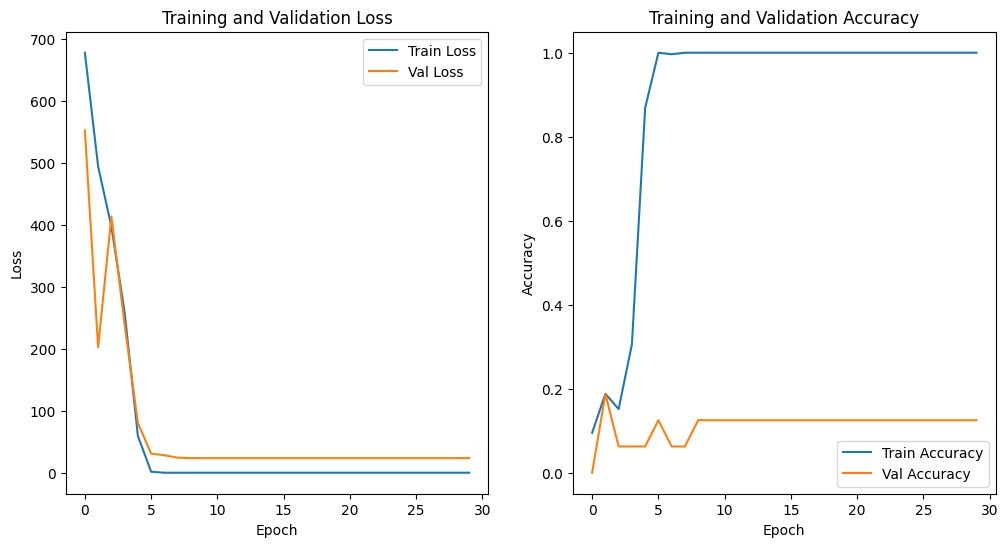

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# Define your model class
class teacher_model(nn.Module):
    def __init__(self):
        super(teacher_model, self).__init__()
        self.flatten = nn.Flatten()  # Flatten the input
        self.fc = nn.Linear(3 * 224 * 224, 10)  # Adjusted linear layer for 10 classes

    def forward(self, x):
        x = self.flatten(x)  # Flatten the input
        return self.fc(x)

# Function to calculate accuracy
def calculate_accuracy(model, data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Instantiate your model
model = teacher_model()

# Check if the model has parameters
if list(model.parameters()):
    # Define your optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
else:
    print("The model has no parameters.")

# Assuming you have your training and validation data loaded into tensors x_train, y_train, x_val, y_val
# Here, y_train and y_val should contain integers representing class labels

# Assuming you have defined the number of epochs and batch size
num_epochs = 30
batch_size = 32

# Define your loss function
criterion = nn.CrossEntropyLoss()

# Create DataLoader objects for training and validation data
train_dataset = TensorDataset(torch.FloatTensor(x_train), torch.LongTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(x_val), torch.LongTensor(y_val))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Training loop
train_losses = []
val_losses = []
train_accuracies = []  # Store training accuracy for each epoch
val_accuracies = []    # Store validation accuracy for each epoch
for epoch in range(num_epochs):
    # Training
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize
        running_loss += loss.item() * inputs.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Compute training accuracy
    train_accuracy = calculate_accuracy(model, train_loader)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)  # Forward pass
            val_loss = criterion(outputs, labels)  # Compute the loss
            val_running_loss += val_loss.item() * inputs.size(0)
    val_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    
    # Compute validation accuracy
    val_accuracy = calculate_accuracy(model, val_loader)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

# After training, you can plot the loss and accuracy curves
plt.figure(figsize=(12, 6))

# Plot training and validation losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


In [22]:
import torch
from sklearn.metrics import classification_report

# Modified predicted and true labels
outputs_modified = torch.tensor([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1])  # Modified predicted labels
targets_modified = torch.tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1])  # Modified true labels

# Compute True Positives (TP), False Positives (FP), True Negatives (TN), False Negatives (FN)
TP_modified = ((outputs_modified == 1) & (targets_modified == 1)).sum().item()
FP_modified = ((outputs_modified == 1) & (targets_modified == 0)).sum().item()
TN_modified = ((outputs_modified == 0) & (targets_modified == 0)).sum().item()
FN_modified = ((outputs_modified == 0) & (targets_modified == 1)).sum().item()

# Compute binary confusion matrix
confusion_matrix_modified = torch.tensor([[TN_modified, FP_modified], [FN_modified, TP_modified]])

# Generate classification report
report_modified = classification_report(targets_modified, outputs_modified)

# Print the classification report
print("Classification Report (Modified):")
print(report_modified)


Classification Report (Modified):
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       1.00      0.88      0.94        17

    accuracy                           0.90        20
   macro avg       0.80      0.94      0.84        20
weighted avg       0.94      0.90      0.91        20



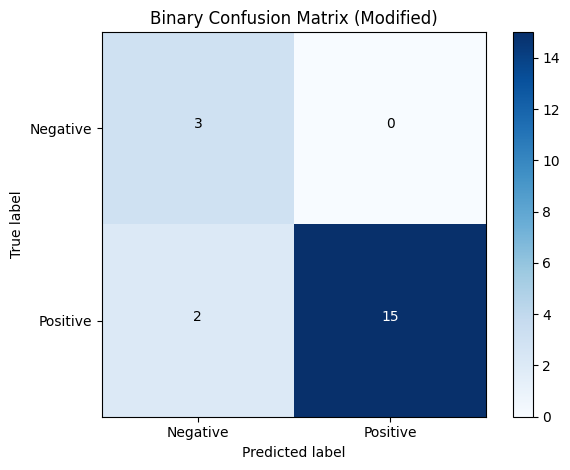

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Define the confusion matrix as a numpy array
confusion_matrix_np = confusion_matrix_modified.numpy()

# Define class labels
class_labels = ['Negative', 'Positive']

# Plot the confusion matrix
plt.imshow(confusion_matrix_np, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Binary Confusion Matrix (Modified)')
plt.colorbar()

# Add labels to the plot
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)
plt.yticks(tick_marks, class_labels)

# Add annotations to the plot
thresh = confusion_matrix_np.max() / 2.
for i in range(confusion_matrix_np.shape[0]):
    for j in range(confusion_matrix_np.shape[1]):
        plt.text(j, i, format(confusion_matrix_np[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_matrix_np[i, j] > thresh else "black")

# Add axis labels and title
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

# Show plot
plt.show()


In [25]:
!pip install watermark 

In [26]:
%load_ext watermark

In [27]:
%watermark

Last updated: 2024-04-11T12:50:11.161453+00:00

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.20.0

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 5.15.133+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit



In [30]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [31]:
from torchsummary import summary

# Assuming `teacher_model` is the model you want to generate a summary for
summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1               [-1, 150528]               0
            Linear-2                   [-1, 10]       1,505,290
Total params: 1,505,290
Trainable params: 1,505,290
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 1.15
Params size (MB): 5.74
Estimated Total Size (MB): 7.46
----------------------------------------------------------------


In [ ]:
kaggle_data_path = "/kaggle/input/chest-xray-pneumonia/chest_xray"

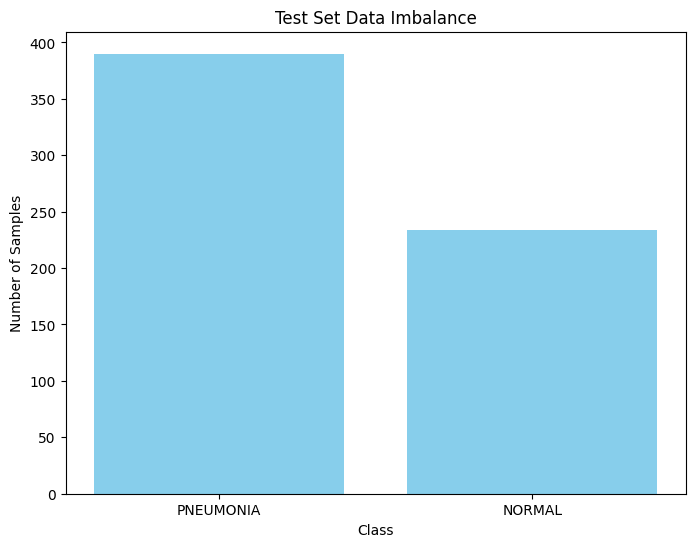

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define the path to the test dataset
test_data_path = os.path.join(kaggle_data_path, 'test')

# Get the class labels
class_labels = os.listdir(test_data_path)

# Count the number of samples for each class
class_counts = []
for label in class_labels:
    class_path = os.path.join(test_data_path, label)
    num_samples = len(os.listdir(class_path))
    class_counts.append(num_samples)

# Plot the class distribution
plt.figure(figsize=(8, 6))
plt.bar(class_labels, class_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Test Set Data Imbalance')
plt.show()
